⚠️ HYBRID

In [1]:
# =====  TUNE ALPHA TRƯỚC KHI CHẠY HYBRID  =====
import numpy as np
import pandas as pd
from pathlib import Path

def _per_user_norm(df, user_col, score_col, method="minmax"):
    g = df.groupby(user_col)[score_col]
    if method == "z":
        mean = g.transform("mean"); std = g.transform("std").replace(0, 1.0)
        df[score_col+"_norm"] = (df[score_col] - mean) / std
    else:
        mn = g.transform("min"); mx = g.transform("max")
        rng = (mx - mn).replace(0, 1.0)
        df[score_col+"_norm"] = (df[score_col] - mn) / rng
    return df.fillna({score_col+"_norm": 0.0})

def _restrict(df, user_col, score_col, k):
    if k is None or df.empty: return df
    return (df.sort_values([user_col, score_col], ascending=[True, False])
              .groupby(user_col, group_keys=False).head(k))

def _dcg_at_k(rel, k):
    rel = np.asarray(rel, dtype=float)[:k]
    if rel.size == 0: return 0.0
    return float(np.sum((2.0**rel - 1.0) / np.log2(np.arange(2, rel.size+2))))

def _ndcg_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    rel  = [1.0 if iid in y_true_set else 0.0 for iid in topk]
    idcg = _dcg_at_k(sorted(rel, reverse=True), k)
    return (_dcg_at_k(rel, k)/idcg) if idcg>0 else 0.0

def _eval_alpha_one_fold(fold, alpha, base_dir, cb_dir, cf_dir,
                         norm="z", k_eval=20, pos_thresh=7, restrict=200):
    cb = pd.read_parquet(cb_dir / f"cb_{fold}.parquet")   # UserID, MovieID, score_cb
    cf = pd.read_parquet(cf_dir / f"cf_{fold}.parquet")   # UserID, MovieID, score_cf

    cb = _restrict(cb, "UserID", "score_cb", restrict)
    cf = _restrict(cf, "UserID", "score_cf", restrict)

    cb = _per_user_norm(cb, "UserID", "score_cb", norm).rename(columns={"score_cb_norm":"cbn"})
    cf = _per_user_norm(cf, "UserID", "score_cf", norm).rename(columns={"score_cf_norm":"cfn"})

    h = cb[["UserID","MovieID","cbn"]].merge(
        cf[["UserID","MovieID","cfn"]],
        on=["UserID","MovieID"], how="outer"
    ).fillna({"cbn":0.0,"cfn":0.0})
    # theo luận văn: score_h = α*CF + (1-α)*CB
    h["score_h"] = alpha*h["cfn"] + (1.0 - alpha)*h["cbn"]

    # test path theo fold1_test.parquet ...
    test_path = base_dir / f"fold{fold.split('_')[1][-1]}_test.parquet"
    if not test_path.exists():
        test_path = base_dir / f"{fold.lower()}_test.parquet"
    test_df = pd.read_parquet(test_path)
    pos = (test_df[test_df["Rating"]>=pos_thresh]
           .groupby("UserID")["MovieID"].apply(set).to_dict())

    if h.empty: return 0.0
    h = h.sort_values(["UserID","score_h"], ascending=[True,False])
    G = h.groupby("UserID")
    users = [u for u in pos.keys() if u in G.groups]
    if not users: return 0.0

    nd = 0.0
    for u in users:
        g = G.get_group(u)
        ranked = list(zip(g["MovieID"].values[:k_eval], g["score_h"].values[:k_eval]))
        nd += _ndcg_at_k(pos[u], ranked, k=k_eval)
    return nd/len(users)

def choose_alpha_before_run(
    alphas=None, norm="z", k_eval=20, pos_thresh=7, restrict=300
):
    if alphas is None:
        alphas = [round(a,2) for a in np.linspace(0.0,1.0,11)]  # 0.00..1.00 step 0.10

    scores = {}
    for a in alphas:
        per_fold = []
        for f in FOLDS:
            s = _eval_alpha_one_fold(f, a, BASE_DIR, CB_DIR, CF_DIR,
                                     norm=norm, k_eval=k_eval, pos_thresh=pos_thresh, restrict=restrict)
            per_fold.append(s)
        scores[a] = float(np.mean(per_fold))
        print(f"alpha={a:.2f} -> nDCG@{k_eval} mean across folds = {scores[a]:.4f}")

    best_alpha = max(scores, key=scores.get)
    print(f"\n[α chọn trước] best alpha = {best_alpha:.2f} (nDCG@{k_eval}={scores[best_alpha]:.4f})")
    return best_alpha


In [2]:
# --- HYBRID (CB + CF) : minimal runner ---
import pandas as pd
from pathlib import Path

# ==== CONFIG (đổi nếu cần) ====
BASE_DIR = Path(r"C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934")
CB_DIR   = BASE_DIR / "cb_out"         # đã export ở file CB
CF_DIR   = BASE_DIR / "cf_out"         # đã export ở file CF (user-based hoặc item-based hoặc SVD)
OUT_DIR  = BASE_DIR / "hybrid_out"
FOLDS    = ("Fold_1","Fold_2","Fold_3")

ALPHA_CF = 0.6        # theo luận văn: weight cho CF
NORM     = "minmax"        # "z" hoặc "minmax"
RESTRICT = 300        # giữ top-K mỗi user ở mỗi nguồn trước khi join (nhanh hơn). Để None nếu muốn full
TOPK     = 50         # export top-K/user

OUT_DIR.mkdir(exist_ok=True)

def per_user_norm(df, user_col, score_col, method="minmax"):
    if df.empty:
        df[score_col+"_norm"] = []
        return df
    g = df.groupby(user_col)[score_col]
    if method == "z":
        mean = g.transform("mean")
        std  = g.transform("std").replace(0, 1.0)
        df[score_col+"_norm"] = (df[score_col] - mean) / std
    else:  # minmax
        mn = g.transform("min"); mx = g.transform("max")
        rng = (mx - mn).replace(0, 1.0)
        df[score_col+"_norm"] = (df[score_col] - mn) / rng
    return df.fillna({score_col+"_norm": 0.0})

def restrict_topk(df, user_col, score_col, k):
    if k is None or df.empty:
        return df
    df = df.sort_values([user_col, score_col], ascending=[True, False])
    return df.groupby(user_col, group_keys=False).head(k)

def run_one_fold(fold):
    cb = pd.read_parquet(CB_DIR / f"cb_{fold}.parquet")   # cols: UserID, MovieID, score_cb
    cf = pd.read_parquet(CF_DIR / f"cf_{fold}.parquet")   # cols: UserID, MovieID, score_cf

    cb = restrict_topk(cb, "UserID", "score_cb", RESTRICT)
    cf = restrict_topk(cf, "UserID", "score_cf", RESTRICT)

    cb = per_user_norm(cb, "UserID", "score_cb", NORM).rename(columns={"score_cb_norm":"cb_norm"})
    cf = per_user_norm(cf, "UserID", "score_cf", NORM).rename(columns={"score_cf_norm":"cf_norm"})

    h = cb[["UserID","MovieID","cb_norm"]].merge(
        cf[["UserID","MovieID","cf_norm"]],
        on=["UserID","MovieID"], how="outer"
    ).fillna({"cb_norm":0.0, "cf_norm":0.0})

    # công thức theo hình: alpha * CF + (1-alpha) * CB
    h["score_hybrid"] = ALPHA_CF*h["cf_norm"] + (1.0-ALPHA_CF)*h["cb_norm"]

    # lưu full + topK
    out_full = OUT_DIR / f"hybrid_{fold}.parquet"
    out_topk = OUT_DIR / f"hybrid_topk_{fold}.parquet"
    h.to_parquet(out_full, index=False)

    h_topk = (h.sort_values(["UserID","score_hybrid"], ascending=[True, False])
                .groupby("UserID", group_keys=False).head(TOPK))
    h_topk.to_parquet(out_topk, index=False)

    print(f"[✓] {fold}: rows={len(h):,} | saved {out_full.name} & {out_topk.name}")

def main():
    for f in FOLDS:
        run_one_fold(f)

if __name__ == "__main__":
    ALPHA_CF = choose_alpha_before_run(
        alphas=[0.90, 0.95, 0.97, 0.99],   # chỉ thử vùng gần 1
        norm=NORM, k_eval=20, pos_thresh=7, restrict=RESTRICT
    )
    print(f"--> dùng ALPHA_CF = {ALPHA_CF:.2f}")

    # 2) chạy hybrid chính với alpha đã chọn
    main()


alpha=0.90 -> nDCG@20 mean across folds = 0.1077
alpha=0.95 -> nDCG@20 mean across folds = 0.1076
alpha=0.97 -> nDCG@20 mean across folds = 0.1075
alpha=0.99 -> nDCG@20 mean across folds = 0.1074

[α chọn trước] best alpha = 0.90 (nDCG@20=0.1077)
--> dùng ALPHA_CF = 0.90
[✓] Fold_1: rows=19,405,939 | saved hybrid_Fold_1.parquet & hybrid_topk_Fold_1.parquet
[✓] Fold_2: rows=19,423,388 | saved hybrid_Fold_2.parquet & hybrid_topk_Fold_2.parquet
[✓] Fold_3: rows=19,472,155 | saved hybrid_Fold_3.parquet & hybrid_topk_Fold_3.parquet


In [3]:
# ====== PRINT HYBRID SCORES ======

import pandas as pd

def print_summary(folds=FOLDS):
    """Tổng hợp số dòng + thống kê score_hybrid theo từng fold."""
    rows = []
    for f in folds:
        df = pd.read_parquet(OUT_DIR / f"hybrid_{f}.parquet")
        rows.append({
            "fold": f,
            "rows": len(df),
            "mean": df["score_hybrid"].mean(),
            "min":  df["score_hybrid"].min(),
            "max":  df["score_hybrid"].max(),
        })
    s = pd.DataFrame(rows, columns=["fold","rows","mean","min","max"])
    print("\n=== Hybrid score summary ===")
    print(s.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x,float) else x))

def print_user_table(user_id, fold="Fold_1", topn=10):
    """In top-N phim theo score_hybrid cho 1 user cụ thể."""
    path = OUT_DIR / f"hybrid_topk_{fold}.parquet"
    df = pd.read_parquet(path)
    sub = (df[df["UserID"] == user_id]
           .sort_values("score_hybrid", ascending=False)
           .head(topn))
    if sub.empty:
        print(f"Không thấy user {user_id} trong {fold}.")
        return
    print(f"\n=== {fold} — User {user_id} (top {len(sub)}) ===")
    print(sub[["MovieID","score_hybrid"]].to_string(index=False,
          float_format=lambda x: f"{x:.4f}"))

def print_preview_per_fold(folds=FOLDS, users_per_fold=3, topn=5):
    """Xem nhanh: với mỗi fold, in top-N cho vài user đầu tiên."""
    for f in folds:
        path = OUT_DIR / f"hybrid_topk_{f}.parquet"
        df = pd.read_parquet(path).sort_values(
            ["UserID","score_hybrid"], ascending=[True, False]
        )
        print(f"\n=== {f}: preview {topn} cho {users_per_fold} user đầu ===")
        for uid in df["UserID"].drop_duplicates().head(users_per_fold):
            sub = df[df["UserID"] == uid].head(topn)
            print(f"\nUser {uid} — top {topn}")
            print(sub[["MovieID","score_hybrid"]].to_string(index=False,
                  float_format=lambda x: f"{x:.4f}"))

# ---- gọi in bảng điểm sau khi chạy main() xong ----
print_summary()                 # thống kê chung theo fold
print_preview_per_fold()        # xem nhanh vài user đầu mỗi fold
# print_user_table(123, "Fold_2", topn=10)  # ví dụ: in cho 1 user cụ thể



=== Hybrid score summary ===
  fold     rows   mean    min    max
Fold_1 19405939 0.0474 0.0000 1.0000
Fold_2 19423388 0.0479 0.0000 1.0000
Fold_3 19472155 0.0485 0.0000 1.0000

=== Fold_1: preview 5 cho 3 user đầu ===

User 1 — top 5
 MovieID  score_hybrid
 3551400        0.1000
 3774802        0.1000
 3163224        0.0987
  120841        0.0897
 4520364        0.0847

User 2 — top 5
 MovieID  score_hybrid
 1408101        0.9000
  770828        0.5963
 1853728        0.5313
 1981677        0.5008
 1670345        0.3193

User 3 — top 5
 MovieID  score_hybrid
 7549996        0.9000
   50083        0.7284
  468569        0.5840
   99685        0.5171
  482571        0.4424

=== Fold_2: preview 5 cho 3 user đầu ===

User 1 — top 5
 MovieID  score_hybrid
 3551400        0.1000
 3774802        0.1000
 3163224        0.0987
  120841        0.0897
 4520364        0.0847

User 2 — top 5
 MovieID  score_hybrid
 1408101        0.9000
 1853728        0.7221
  770828        0.6412
 1981677      

Đây là top 5 phim được gợi ý cho User 1 trong Fold_1.

score_hybrid = α * CF + (1 - α) * CB, tức điểm kết hợp giữa Collaborative Filtering và Content-based.

Giá trị càng cao → phim càng được ưu tiên khuyến nghị cho user đó

In [4]:
# ===== EVALUATE HYBRID TOP-K TỪ PARQUET =====
import numpy as np
import pandas as pd
from pathlib import Path

BASE_DIR = Path(r"C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934")
OUT_DIR  = BASE_DIR / "hybrid_out"
FOLDS    = ("Fold_1","Fold_2","Fold_3")
POS_LIST = (7, 8)
KS       = (10, 20, 50)

# ---- metrics (độc lập, không cần import từ file khác) ----
def precision_recall_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    hit  = sum(1 for iid in topk if iid in y_true_set)
    p = hit / max(1, len(topk))
    r = hit / max(1, len(y_true_set))
    return p, r

def hitrate_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    return 1.0 if any(i in y_true_set for i in topk) else 0.0

def average_precision_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    ap, hits = 0.0, 0
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            hits += 1
            ap += hits / i
    return ap / max(1, min(len(y_true_set), k))

def _dcg_at_k(rel, k):
    rel = np.asarray(rel, dtype=float)[:k]
    if rel.size == 0: return 0.0
    return float(np.sum((2.0**rel - 1.0) / np.log2(np.arange(2, rel.size+2))))

def ndcg_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    rel  = [1.0 if iid in y_true_set else 0.0 for iid in topk]
    idcg = _dcg_at_k(sorted(rel, reverse=True), k)
    return (_dcg_at_k(rel, k)/idcg) if idcg > 0 else 0.0

def mrr_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            return 1.0 / i
    return 0.0

# ---- test set loader (đọc trực tiếp parquet nhẹ, không cần load_checkpoint) ----
def test_df_for_fold(fold_name: str) -> pd.DataFrame:
    # ưu tiên "fold1_test.parquet", fallback "fold_1_test.parquet" hay "fold1_test.snappy.parquet" nếu bạn đổi đuôi
    idx = fold_name.split("_")[1]  # "1","2","3"
    candidates = [
        BASE_DIR / f"fold{idx}_test.parquet",
        BASE_DIR / f"{fold_name.lower()}_test.parquet",
        BASE_DIR / f"Fold_{idx}_test.parquet",
    ]
    for p in candidates:
        if p.exists():
            return pd.read_parquet(p)
    raise FileNotFoundError(f"Không tìm thấy test parquet cho {fold_name} trong {BASE_DIR}")

def eval_one_fold(fold, pos_thresh=7, ks=KS):
    # đọc top-k hybrid đã lưu
    recs = pd.read_parquet(OUT_DIR / f"hybrid_topk_{fold}.parquet")  # UserID, MovieID, score_hybrid
    recs = recs.sort_values(["UserID","score_hybrid"], ascending=[True, False])
    grouped = recs.groupby("UserID")
    recs_by_user = {u: list(zip(g["MovieID"].values, g["score_hybrid"].values))
                    for u, g in grouped}

    # positives ở test
    test_df = test_df_for_fold(fold)
    pos = (test_df[test_df["Rating"] >= pos_thresh]
           .groupby("UserID")["MovieID"].apply(lambda s: set(s.values)).to_dict())

    users_eval = [u for u in pos if u in recs_by_user and len(recs_by_user[u]) > 0]
    if not users_eval:
        return {"users_eval": 0, "pos_thresh": pos_thresh, "fold": fold}

    out = {"users_eval": len(users_eval), "pos_thresh": pos_thresh, "fold": fold}
    for K in ks:
        HR=P=Rcl=MAP=NDCG=MRR=0.0
        for u in users_eval:
            truth  = pos[u]
            ranked = recs_by_user[u]  # đã sắp giảm dần; metrics sẽ cắt [:K]
            pk, rk = precision_recall_at_k(truth, ranked, k=K)
            HR    += hitrate_at_k(truth, ranked, k=K)
            P     += pk; Rcl += rk
            MAP   += average_precision_at_k(truth, ranked, k=K)
            NDCG  += ndcg_at_k(truth, ranked, k=K)
            MRR   += mrr_at_k(truth, ranked, k=K)
        n = len(users_eval)
        out.update({
            f"hit@{K}":       float(HR/n),
            f"precision@{K}": float(P/n),
            f"recall@{K}":    float(Rcl/n),
            f"map@{K}":       float(MAP/n),
            f"ndcg@{K}":      float(NDCG/n),
            f"mrr@{K}":       float(MRR/n),
        })
    return out

# ---- chạy qua fold & tổng hợp ----
rows = []
for fold in FOLDS:
    for pos in POS_LIST:
        m = eval_one_fold(fold, pos_thresh=pos, ks=KS)
        rows.append(m)
        present = sorted([k for k in m.keys() if "@" in k])
        print(f"[{fold}] POS≥{pos} | users_eval={m['users_eval']} | "
              f"{ {k: round(m[k],4) for k in present} }")

hyb_eval_df = pd.DataFrame(rows)

print("\n=== HYBRID — mean across folds ===")
if not hyb_eval_df.empty:
    metric_cols = [c for c in hyb_eval_df.columns if "@" in c]
    print(hyb_eval_df.groupby("pos_thresh")[metric_cols].mean().round(4))
else:
    print("hyb_eval_df rỗng.")


[Fold_1] POS≥7 | users_eval=23310 | {'hit@10': 0.1789, 'hit@20': 0.2574, 'hit@50': 0.3808, 'map@10': 0.0225, 'map@20': 0.0233, 'map@50': 0.0249, 'mrr@10': 0.0741, 'mrr@20': 0.0795, 'mrr@50': 0.0834, 'ndcg@10': 0.0979, 'ndcg@20': 0.117, 'ndcg@50': 0.1402, 'precision@10': 0.0222, 'precision@20': 0.0179, 'precision@50': 0.0128, 'recall@10': 0.0466, 'recall@20': 0.0686, 'recall@50': 0.1121}
[Fold_1] POS≥8 | users_eval=22075 | {'hit@10': 0.1615, 'hit@20': 0.2316, 'hit@50': 0.346, 'map@10': 0.0241, 'map@20': 0.0255, 'map@50': 0.0273, 'mrr@10': 0.0666, 'mrr@20': 0.0714, 'mrr@50': 0.075, 'ndcg@10': 0.0882, 'ndcg@20': 0.1052, 'ndcg@50': 0.1267, 'precision@10': 0.0195, 'precision@20': 0.0155, 'precision@50': 0.0108, 'recall@10': 0.0523, 'recall@20': 0.0766, 'recall@50': 0.1236}
[Fold_2] POS≥7 | users_eval=23163 | {'hit@10': 0.1638, 'hit@20': 0.2345, 'hit@50': 0.3516, 'map@10': 0.0231, 'map@20': 0.0241, 'map@50': 0.0258, 'mrr@10': 0.0688, 'mrr@20': 0.0737, 'mrr@50': 0.0774, 'ndcg@10': 0.0902, 'nd

In [5]:
# ===== EVAL CB & CF TỪ FILE cb_out / cf_out (cùng style với hybrid) =====
import numpy as np
import pandas as pd
from pathlib import Path

# THAM SỐ DÙNG LẠI
POS_LIST = (7, 8)
KS       = (10, 20, 50)

def precision_recall_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    hit  = sum(1 for iid in topk if iid in y_true_set)
    p = hit / max(1, len(topk))
    r = hit / max(1, len(y_true_set))
    return p, r

def hitrate_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    return 1.0 if any(i in y_true_set for i in topk) else 0.0

def average_precision_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    ap, hits = 0.0, 0
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            hits += 1
            ap += hits / i
    return ap / max(1, min(len(y_true_set), k))

def _dcg_at_k(rel, k):
    rel = np.asarray(rel, dtype=float)[:k]
    if rel.size == 0: return 0.0
    return float(np.sum((2.0**rel - 1.0) / np.log2(np.arange(2, rel.size+2))))

def ndcg_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    rel  = [1.0 if iid in y_true_set else 0.0 for iid in topk]
    idcg = _dcg_at_k(sorted(rel, reverse=True), k)
    return (_dcg_at_k(rel, k)/idcg) if idcg > 0 else 0.0

def mrr_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            return 1.0 / i
    return 0.0

def test_df_for_fold(fold_name: str) -> pd.DataFrame:
    idx = fold_name.split("_")[1]  # "1","2","3"
    candidates = [
        BASE_DIR / f"fold{idx}_test.parquet",
        BASE_DIR / f"{fold_name.lower()}_test.parquet",
        BASE_DIR / f"Fold_{idx}_test.parquet",
    ]
    for p in candidates:
        if p.exists():
            return pd.read_parquet(p)
    raise FileNotFoundError(f"Không tìm thấy test parquet cho {fold_name}")

def eval_model_dir(model_dir, file_prefix, score_col, pos_list=POS_LIST, ks=KS):
    rows = []
    for fold in FOLDS:
        recs = pd.read_parquet(model_dir / f"{file_prefix}_{fold}.parquet")
        recs = recs.sort_values(["UserID", score_col], ascending=[True, False])
        grouped = recs.groupby("UserID")

        test_df = test_df_for_fold(fold)

        for pos_thresh in pos_list:
            pos = (test_df[test_df["Rating"] >= pos_thresh]
                   .groupby("UserID")["MovieID"].apply(lambda s: set(s.values)).to_dict())

            users_eval = [u for u in pos if u in grouped.groups]
            if not users_eval:
                rows.append({"fold": fold, "pos_thresh": pos_thresh, "users_eval": 0})
                continue

            out = {"fold": fold, "pos_thresh": pos_thresh, "users_eval": len(users_eval)}
            for K in ks:
                HR=P=Rcl=MAP=NDCG=MRR = 0.0
                for u in users_eval:
                    g = grouped.get_group(u)
                    ranked = list(zip(g["MovieID"].values, g[score_col].values))
                    truth  = pos[u]
                    pk, rk = precision_recall_at_k(truth, ranked, k=K)
                    HR    += hitrate_at_k(truth, ranked, k=K)
                    P     += pk; Rcl += rk
                    MAP   += average_precision_at_k(truth, ranked, k=K)
                    NDCG  += ndcg_at_k(truth, ranked, k=K)
                    MRR   += mrr_at_k(truth, ranked, k=K)
                n = len(users_eval)
                out.update({
                    f"hit@{K}":       float(HR/n),
                    f"precision@{K}": float(P/n),
                    f"recall@{K}":    float(Rcl/n),
                    f"map@{K}":       float(MAP/n),
                    f"ndcg@{K}":      float(NDCG/n),
                    f"mrr@{K}":       float(MRR/n),
                })
            rows.append(out)
    return pd.DataFrame(rows)

# TÍNH CB, CF(user-based) VÀ CF(SVD) TỪ FILE ĐÃ EXPORT
cb_results_df  = eval_model_dir(CB_DIR, "cb",   "score_cb")
ub_results_df  = eval_model_dir(CF_DIR, "cf",   "score_cf")   # user-based
svd_results_df = eval_model_dir(CF_DIR, "svd",  "score_cf")   # truncated SVD

print("CB results:\n", cb_results_df.groupby("pos_thresh")["ndcg@10"].mean().round(4))
print("\nCF(user) results:\n", ub_results_df.groupby("pos_thresh")["ndcg@10"].mean().round(4))
print("\nCF(SVD) results:\n", svd_results_df.groupby("pos_thresh")["ndcg@10"].mean().round(4))

CB results:
 pos_thresh
7    0.0177
8    0.0127
Name: ndcg@10, dtype: float64

CF(user) results:
 pos_thresh
7    0.0917
8    0.0846
Name: ndcg@10, dtype: float64

CF(SVD) results:
 pos_thresh
7    0.0970
8    0.0903
Name: ndcg@10, dtype: float64


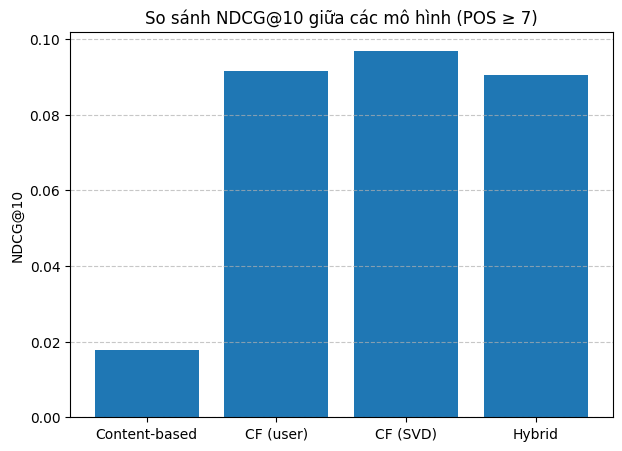

In [6]:
import matplotlib.pyplot as plt
import numpy as np

pos = 7
metric = "ndcg@10"

cb_mean   = cb_results_df [cb_results_df ['pos_thresh']==pos][metric].mean()
cf_mean   = ub_results_df [ub_results_df ['pos_thresh']==pos][metric].mean()      # user-based
svd_mean  = svd_results_df[svd_results_df['pos_thresh']==pos][metric].mean()     # SVD
hyb_mean  = hyb_eval_df   [hyb_eval_df   ['pos_thresh']==pos][metric].mean()     # hybrid

labels = ["Content-based", "CF (user)", "CF (SVD)", "Hybrid"]
values = [cb_mean, cf_mean, svd_mean, hyb_mean]

plt.figure(figsize=(7,5))
plt.bar(labels, values)
plt.ylabel("NDCG@10")
plt.title("So sánh NDCG@10 giữa các mô hình (POS ≥ 7)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [7]:
POS = 7
metrics = ["hit@10", "precision@10", "recall@10", "ndcg@10"]

def get_row(df, name):
    sub = df[df["pos_thresh"] == POS]
    row = {"Model": name}
    for m in metrics:
        if m in sub.columns:
            row[m] = sub[m].mean()
    return row

rows = [
    get_row(cb_results_df,  "Content-based"),
    get_row(ub_results_df,  "CF (user)"),
    get_row(svd_results_df, "CF (SVD)"),
    get_row(hyb_eval_df,    "Hybrid"),
]

compare_df = pd.DataFrame(rows)
print("=== So sánh các chỉ số (POS ≥ 7, K = 10) ===")
print(compare_df.round(4).to_string(index=False))



=== So sánh các chỉ số (POS ≥ 7, K = 10) ===
        Model  hit@10  precision@10  recall@10  ndcg@10
Content-based  0.0329        0.0037     0.0082   0.0177
    CF (user)  0.1667        0.0204     0.0498   0.0917
     CF (SVD)  0.1772        0.0215     0.0450   0.0970
       Hybrid  0.1643        0.0201     0.0492   0.0905


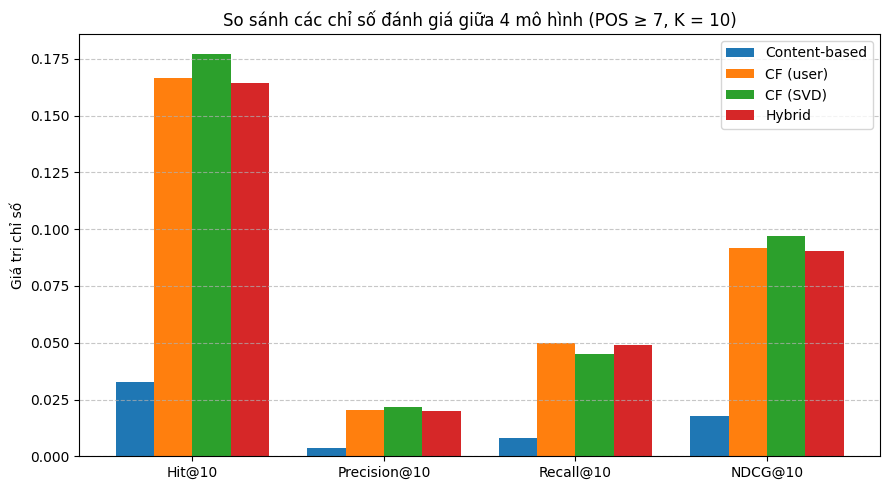

In [8]:
POS = 7
metrics = ["hit@10", "precision@10", "recall@10", "ndcg@10"]
metric_labels = ["Hit@10", "Precision@10", "Recall@10", "NDCG@10"]

def vals(df):
    sub = df[df["pos_thresh"] == POS]
    return [sub[m].mean() for m in metrics]

cb_vals   = vals(cb_results_df)
cf_vals   = vals(ub_results_df)
svd_vals  = vals(svd_results_df)
hyb_vals  = vals(hyb_eval_df)

x = np.arange(len(metrics))         # vị trí các nhóm metric
width = 0.2                         # độ rộng mỗi cột

plt.figure(figsize=(9,5))
plt.bar(x - 1.5*width, cb_vals,   width, label="Content-based")
plt.bar(x - 0.5*width, cf_vals,   width, label="CF (user)")
plt.bar(x + 0.5*width, svd_vals,  width, label="CF (SVD)")
plt.bar(x + 1.5*width, hyb_vals,  width, label="Hybrid")

plt.xticks(x, metric_labels)
plt.ylabel("Giá trị chỉ số")
plt.title("So sánh các chỉ số đánh giá giữa 4 mô hình (POS ≥ 7, K = 10)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

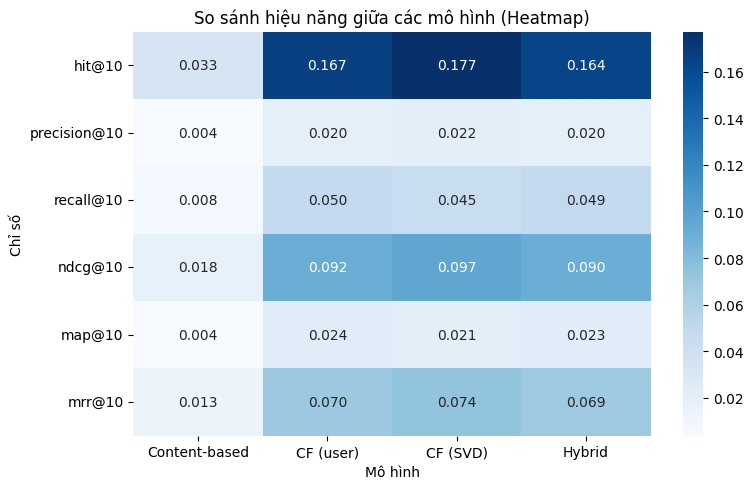

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

POS = 7
metrics = ["hit@10","precision@10","recall@10","ndcg@10","map@10","mrr@10"]

rows = {
    "Content-based": [cb_results_df[cb_results_df['pos_thresh']==POS][m].mean() for m in metrics],
    "CF (user)":     [ub_results_df[ub_results_df['pos_thresh']==POS][m].mean() for m in metrics],
    "CF (SVD)":      [svd_results_df[svd_results_df['pos_thresh']==POS][m].mean() for m in metrics],
    "Hybrid":        [hyb_eval_df[hyb_eval_df['pos_thresh']==POS][m].mean() for m in metrics],
}

df = pd.DataFrame(rows, index=metrics)

plt.figure(figsize=(8,5))
sns.heatmap(df, annot=True, cmap="Blues", fmt=".3f")
plt.title("So sánh hiệu năng giữa các mô hình (Heatmap)")
plt.ylabel("Chỉ số")
plt.xlabel("Mô hình")
plt.tight_layout()
plt.show()


# === Phân nhóm cold-start: user có <= 5 rating trong train ===
cold_users = {}
for fold_name in FOLDS:
    train_df = pd.read_parquet(BASE_DIR / f"fold{fold_name.split('_')[1]}_train.parquet")
    cnt = train_df.groupby("UserID")["Rating"].count()
    cold_users[fold_name] = set(cnt[cnt <= 5].index)  # threshold = 5


# === Đánh giá cold-start riêng cho từng mô hình ===
def eval_coldstart(model_dir, prefix, score_col, cold_users):
    rows = []
    for fold in FOLDS:
        recs = pd.read_parquet(model_dir / f"{prefix}_{fold}.parquet")
        fold_cold = cold_users[fold]

        # Lọc đúng user cold-start
        recs = recs[recs["UserID"].isin(fold_cold)]
        recs = recs.sort_values(["UserID", score_col], ascending=[True, False])
        grouped = recs.groupby("UserID")

        # Lấy tập positive ở test
        test_df = test_df_for_fold(fold)
        pos = (test_df[test_df["Rating"] >= 7]
               .groupby("UserID")["MovieID"].apply(lambda s: set(s.values)))

        out = []
        for user in fold_cold:
            if user not in grouped or user not in pos:
                continue
            g = grouped.get_group(user)
            ranked = list(zip(g["MovieID"].values, g[score_col].values))
            out.append(ndcg_at_k(pos[user], ranked, k=10))

        rows.append({
            "fold": fold,
            "cold_users": len(fold_cold),
            "ndcg@10": float(np.mean(out)) if out else 0.0
        })
    return pd.DataFrame(rows)



print("\nCB cold-start:")
print(eval_coldstart(CB_DIR, "cb", "score_cb", cold_users))

print("\nCF_user cold-start:")
print(eval_coldstart(CF_DIR, "cf", "score_cf", cold_users))

print("\nCF_SVD cold-start:")
print(eval_coldstart(CF_DIR, "svd", "score_cf", cold_users))

print("\nHybrid cold-start:")
print(eval_coldstart(OUT_DIR, "hybrid_topk", "score_hybrid", cold_users))



In [15]:
FOLD   = "Fold_1"
USER   = 1
TOP_K  = 10

print(f"\n=== Top-{TOP_K} gợi ý cho User {USER} (Fold: {FOLD}) ===")

# 1) CF (USER-BASED)
try:
    df_cf = pd.read_parquet(CF_DIR / f"cf_{FOLD}.parquet")   # cols: UserID, MovieID, score_cf
    sub_cf = (df_cf[df_cf["UserID"] == USER]
              .sort_values("score_cf", ascending=False)
              .head(TOP_K))
    print(f"\n[CF - User-based] — Top-{TOP_K}")
    if sub_cf.empty:
        print("  (User không có trong kết quả CF(user))")
    else:
        for i, row in enumerate(sub_cf.itertuples(index=False), 1):
            print(f"  {i:2d}. {row.MovieID:<8} | {row.score_cf:6.4f}")
except Exception as e:
    print("[CF(user)] Lỗi đọc hoặc in:", e)

# 2) CF (TRUNCATED SVD)
try:
    df_svd = pd.read_parquet(CF_DIR / f"svd_{FOLD}.parquet")  # cols: UserID, MovieID, score_cf
    sub_svd = (df_svd[df_svd["UserID"] == USER]
               .sort_values("score_cf", ascending=False)
               .head(TOP_K))
    print(f"\n[CF - Truncated SVD] — Top-{TOP_K}")
    if sub_svd.empty:
        print("  (User không có trong kết quả SVD)")
    else:
        for i, row in enumerate(sub_svd.itertuples(index=False), 1):
            print(f"  {i:2d}. {row.MovieID:<8} | {row.score_cf:6.4f}")
except Exception as e:
    print("[SVD] Lỗi đọc hoặc in:", e)



=== Top-10 gợi ý cho User 1 (Fold: Fold_1) ===

[CF - User-based] — Top-10
  (User không có trong kết quả CF(user))

[CF - Truncated SVD] — Top-10
   1. 8        | 8.0000
   2. 15831978 | 8.0000
   3. 15655276 | 8.0000
   4. 15293256 | 8.0000
   5. 15219436 | 8.0000
   6. 15141288 | 8.0000
   7. 15112954 | 8.0000
   8. 15101946 | 8.0000
   9. 15097216 | 8.0000
  10. 15095938 | 8.0000


In [16]:
FOLD  = "Fold_1"
TOP_K = 10

# Load 4 nguồn
df_cb   = pd.read_parquet(CB_DIR   / f"cb_{FOLD}.parquet")          # UserID, MovieID, score_cb
df_cf   = pd.read_parquet(CF_DIR   / f"cf_{FOLD}.parquet")          # UserID, MovieID, score_cf (user-based)
df_svd  = pd.read_parquet(CF_DIR   / f"svd_{FOLD}.parquet")         # UserID, MovieID, score_cf (SVD)
df_hyb  = pd.read_parquet(OUT_DIR  / f"hybrid_topk_{FOLD}.parquet") # UserID, MovieID, score_hybrid

# Tìm user xuất hiện trong cả 4 mô hình
users_cb  = set(df_cb["UserID"].unique())
users_cf  = set(df_cf["UserID"].unique())
users_svd = set(df_svd["UserID"].unique())
users_hyb = set(df_hyb["UserID"].unique())

common_users = sorted(list(users_cb & users_cf & users_svd & users_hyb))

if not common_users:
    print("Không tìm được user nào xuất hiện trong cả 4 mô hình ở", FOLD)
else:
    USER = common_users[0]   # chọn user đầu tiên để minh họa
    print(f"\n=== Ví dụ Top-{TOP_K} gợi ý cho User {USER} (Fold: {FOLD}) ===")

    # 1) CONTENT-BASED
    sub_cb = (df_cb[df_cb["UserID"] == USER]
              .sort_values("score_cb", ascending=False)
              .head(TOP_K))
    print(f"\n[Content-based] — Top-{TOP_K}")
    for i, row in enumerate(sub_cb.itertuples(index=False), 1):
        print(f"  {i:2d}. {row.MovieID:<8} | {row.score_cb:6.4f}")

    # 2) CF (USER-BASED)
    sub_cf = (df_cf[df_cf["UserID"] == USER]
              .sort_values("score_cf", ascending=False)
              .head(TOP_K))
    print(f"\n[CF - User-based] — Top-{TOP_K}")
    for i, row in enumerate(sub_cf.itertuples(index=False), 1):
        print(f"  {i:2d}. {row.MovieID:<8} | {row.score_cf:6.4f}")

    # 3) CF (TRUNCATED SVD)
    sub_svd = (df_svd[df_svd["UserID"] == USER]
               .sort_values("score_cf", ascending=False)
               .head(TOP_K))
    print(f"\n[CF - Truncated SVD] — Top-{TOP_K}")
    for i, row in enumerate(sub_svd.itertuples(index=False), 1):
        print(f"  {i:2d}. {row.MovieID:<8} | {row.score_cf:6.4f}")

    # 4) HYBRID
    sub_hyb = (df_hyb[df_hyb["UserID"] == USER]
               .sort_values("score_hybrid", ascending=False)
               .head(TOP_K))
    print(f"\n[Hybrid] — Top-{TOP_K}")
    for i, row in enumerate(sub_hyb.itertuples(index=False), 1):
        print(f"  {i:2d}. {row.MovieID:<8} | {row.score_hybrid:6.4f}")



=== Ví dụ Top-10 gợi ý cho User 2 (Fold: Fold_1) ===

[Content-based] — Top-10
   1. 1477834  | 0.7788
   2. 800369   | 0.7684
   3. 1098327  | 0.7556
   4. 1104001  | 0.7269
   5. 4296026  | 0.7014
   6. 4154796  | 0.6996
   7. 1731141  | 0.6991
   8. 834001   | 0.6966
   9. 3297792  | 0.6881
  10. 974015   | 0.6859

[CF - User-based] — Top-10
   1. 1408101  | 6.1920
   2. 770828   | 6.1272
   3. 1853728  | 6.1133
   4. 1981677  | 6.1068
   5. 1670345  | 6.0681
   6. 1817273  | 6.0646
   7. 848228   | 6.0615
   8. 1130884  | 6.0610
   9. 1273235  | 6.0455
  10. 1291584  | 6.0454

[CF - Truncated SVD] — Top-10
   1. 1408101  | 6.2347
   2. 1663662  | 6.1117
   3. 2872732  | 6.0942
   4. 1798709  | 6.0932
   5. 770828   | 6.0858
   6. 1343092  | 6.0830
   7. 1663202  | 6.0768
   8. 2024544  | 6.0755
   9. 1979320  | 6.0717
  10. 468569   | 6.0703

[Hybrid] — Top-10
   1. 1408101  | 0.9000
   2. 770828   | 0.5963
   3. 1853728  | 0.5313
   4. 1981677  | 0.5008
   5. 1670345  | 0.3193
  

In [17]:
FOLD = "Fold_1"
USER = 2
TOP_K = 10

df_cb  = pd.read_parquet(CB_DIR / f"cb_{FOLD}.parquet")
df_cf  = pd.read_parquet(CF_DIR / f"cf_{FOLD}.parquet")
df_svd = pd.read_parquet(CF_DIR / f"svd_{FOLD}.parquet")

def print_topk(df, user, score_col, name, k):
    sub = (df[df["UserID"] == user]
           .sort_values(score_col, ascending=False)
           .head(k))
    print(f"\n[{name}] — Top-{k}")
    print(sub[["MovieID", score_col]].to_string(index=False))

print(f"=== Ví dụ Top-{TOP_K} gợi ý cho User {USER} (Fold: {FOLD}) ===")

print_topk(df_cb,  USER, "score_cb",  "Content-based",      TOP_K)
print_topk(df_cf,  USER, "score_cf",  "CF - User-based",    TOP_K)
print_topk(df_svd, USER, "score_cf",  "CF - Truncated SVD", TOP_K)



=== Ví dụ Top-10 gợi ý cho User 2 (Fold: Fold_1) ===

[Content-based] — Top-10
 MovieID  score_cb
 1477834  0.778843
  800369  0.768399
 1098327  0.755591
 1104001  0.726922
 4296026  0.701384
 4154796  0.699627
 1731141  0.699139
  834001  0.696580
 3297792  0.688111
  974015  0.685911

[CF - User-based] — Top-10
 MovieID  score_cf
 1408101  6.191958
  770828  6.127179
 1853728  6.113318
 1981677  6.106806
 1670345  6.068100
 1817273  6.064577
  848228  6.061547
 1130884  6.060997
 1273235  6.045465
 1291584  6.045423

[CF - Truncated SVD] — Top-10
 MovieID  score_cf
 1408101  6.234715
 1663662  6.111652
 2872732  6.094176
 1798709  6.093215
  770828  6.085847
 1343092  6.083027
 1663202  6.076811
 2024544  6.075541
 1979320  6.071733
  468569  6.070315


In [18]:
FOLD = "Fold_1"
USER = 2
TOP_K = 10

df_cb  = pd.read_parquet(CB_DIR / f"cb_{FOLD}.parquet")
df_cf  = pd.read_parquet(CF_DIR / f"cf_{FOLD}.parquet")
df_svd = pd.read_parquet(CF_DIR / f"svd_{FOLD}.parquet")

# ======= LOAD MOVIE TITLES =======
movies_df = pd.read_parquet(BASE_DIR / "data_clean.parquet")
movies_df = movies_df.drop_duplicates("MovieID")
movie_title = dict(zip(movies_df["MovieID"], movies_df["Title"]))
# =================================


def print_topk(df, user, score_col, name, k):
    sub = (df[df["UserID"] == user]
           .sort_values(score_col, ascending=False)
           .head(k)
           .copy())

    # thêm Title
    sub["Title"] = sub["MovieID"].map(movie_title).fillna("N/A")

    print(f"\n[{name}] — Top-{k}")
    print(sub[["MovieID", "Title", score_col]].to_string(index=False))


print(f"=== Ví dụ Top-{TOP_K} gợi ý cho User {USER} (Fold: {FOLD}) ===")

print_topk(df_cb,  USER, "score_cb",  "Content-based",      TOP_K)
print_topk(df_cf,  USER, "score_cf",  "CF - User-based",    TOP_K)
print_topk(df_svd, USER, "score_cf",  "CF - Truncated SVD", TOP_K)


=== Ví dụ Top-10 gợi ý cho User 2 (Fold: Fold_1) ===

[Content-based] — Top-10
 MovieID                                 Title  score_cb
 1477834                        Aquaman (2018)  0.778843
  800369                           Thor (2011)  0.768399
 1098327           Dragonball Evolution (2009)  0.755591
 1104001                           Tron (2010)  0.726922
 4296026                 Avengers Grimm (2015)  0.701384
 4154796              Avengers: Endgame (2019)  0.699627
 1731141               Ender X27;S Game (2013)  0.699139
  834001 Underworld: Rise Of The Lycans (2009)  0.696580
 3297792                       Survivor (2014)  0.688111
  974015                 Justice League (2017)  0.685911

[CF - User-based] — Top-10
 MovieID                             Title  score_cf
 1408101    Star Trek Into Darkness (2013)  6.191958
  770828               Man Of Steel (2013)  6.127179
 1853728           Django Unchained (2012)  6.113318
 1981677              Pitch Perfect (2012)  6.106806
 

In [19]:
# ===== MINH HỌA: HYBRID GỢI Ý ĐƯỢC PHIM COLD-START (CF KHÔNG LÀM ĐƯỢC) =====
import pandas as pd
from pathlib import Path

BASE_DIR = Path(r"C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934")
CB_DIR   = BASE_DIR / "cb_out"
CF_DIR   = BASE_DIR / "cf_out"
OUT_DIR  = BASE_DIR / "hybrid_out"
FOLD     = "Fold_1"
POS_THRESH = 7      # ngưỡng phim user thật sự thích
TOPK       = 20     # xem top-K trong hybrid

def test_df_for_fold(fold_name: str) -> pd.DataFrame:
    """Đọc lại test set của 1 fold (dùng y hệt hàm bạn đã có trong file eval)."""
    idx = fold_name.split("_")[1]  # "1","2","3"
    for p in [
        BASE_DIR / f"fold{idx}_test.parquet",
        BASE_DIR / f"{fold_name.lower()}_test.parquet",
        BASE_DIR / f"Fold_{idx}_test.parquet",
    ]:
        if p.exists():
            return pd.read_parquet(p)
    raise FileNotFoundError(f"Không tìm thấy test parquet cho {fold_name}")

def find_coldstart_hybrid_example(fold=FOLD, pos_thresh=POS_THRESH, topk=TOPK):
    # 1) load test + dự đoán CF & Hybrid
    test_df   = test_df_for_fold(fold)
    cf_pred   = pd.read_parquet(CF_DIR  / f"cf_{fold}.parquet")          # UserID, MovieID, score_cf
    hyb_topk  = pd.read_parquet(OUT_DIR / f"hybrid_topk_{fold}.parquet") # UserID, MovieID, score_hybrid

    # toàn bộ phim CF có thể dự đoán
    cf_items = set(cf_pred["MovieID"].unique())

    # 2) xác định các phim "mới" đối với CF (xuất hiện ở test nhưng không có trong cf_pred)
    all_test_items   = set(test_df["MovieID"].unique())
    cold_items_cf    = all_test_items - cf_items
    print(f"{fold}: có {len(cold_items_cf)} phim cold-start đối với CF")

    # 3) những phim cold-start mà user trong test thực sự thích (Rating >= pos_thresh)
    pos_cold = test_df[(test_df["Rating"] >= pos_thresh) &
                       (test_df["MovieID"].isin(cold_items_cf))]

    if pos_cold.empty:
        print("Không có user nào thích phim cold-start trong test (POS ≥ thresh).")
        return

    liked_cold_by_user = pos_cold.groupby("UserID")["MovieID"].apply(set).to_dict()

    # 4) group hybrid top-K theo user để tra cứu
    hyb_topk = hyb_topk.sort_values(["UserID","score_hybrid"], ascending=[True, False])
    hyb_group = hyb_topk.groupby("UserID")

    # 5) tìm 1 ví dụ: user có ít nhất 1 phim cold-start xuất hiện trong top-K hybrid
    for u, cold_set in liked_cold_by_user.items():
        if u not in hyb_group.groups:
            continue
        recs = hyb_group.get_group(u).head(topk)
        rec_ids = list(recs["MovieID"].values)
        hit_items = cold_set & set(rec_ids)
        if not hit_items:
            continue

        # lấy 1 phim minh hoạ
        movie_id = next(iter(hit_items))
        rank = rec_ids.index(movie_id) + 1
        score_h = float(recs.loc[recs["MovieID"] == movie_id, "score_hybrid"].iloc[0])

        print("\n=== VÍ DỤ HYBRID GỢI Ý ĐƯỢC PHIM COLD-START (CF KHÔNG CÓ) ===")
        print(f"Fold: {fold}")
        print(f"User ID: {u}")
        print(f"Movie ID (cold-start đối với CF): {movie_id}")
        print(f"– Phim này xuất hiện trong test với Rating ≥ {pos_thresh}")
        print(f"– Hybrid xếp phim này ở vị trí #{rank} trong Top-{topk}, score_hybrid = {score_h:.4f}")

        # chứng minh CF thật sự không dự đoán được phim này
        exists_in_cf = ((cf_pred["UserID"] == u) & (cf_pred["MovieID"] == movie_id)).any()
        print(f"– Trong bảng dự đoán CF (cf_{fold}.parquet) "
              f"phim này {'CÓ' if exists_in_cf else 'KHÔNG'} xuất hiện cho user {u}.")

        # nếu muốn xem điểm Content-based gốc:
        try:
            cb_pred = pd.read_parquet(CB_DIR / f"cb_{fold}.parquet")
            cb_rows = cb_pred[(cb_pred["UserID"] == u) & (cb_pred["MovieID"] == movie_id)]
            if not cb_rows.empty:
                cb_score = float(cb_rows["score_cb"].iloc[0])
                print(f"– Điểm Content-based gốc cho phim này: score_cb = {cb_score:.4f}")
        except FileNotFoundError:
            pass

        print("\n=> Kết luận: đây là ví dụ cụ thể cho thấy nhánh Content-based "
              "giúp Hybrid vẫn gợi ý được một bộ phim mới (cold-start đối với CF).")
        return

    print("Không tìm được ví dụ user nào vừa thích phim cold-start vừa được Hybrid gợi ý trong Top-K.")

# GỌI HÀM MINH HOẠ
find_coldstart_hybrid_example()


Fold_1: có 9800 phim cold-start đối với CF

=== VÍ DỤ HYBRID GỢI Ý ĐƯỢC PHIM COLD-START (CF KHÔNG CÓ) ===
Fold: Fold_1
User ID: 12663
Movie ID (cold-start đối với CF): 9054192
– Phim này xuất hiện trong test với Rating ≥ 7
– Hybrid xếp phim này ở vị trí #13 trong Top-20, score_hybrid = 0.1000
– Trong bảng dự đoán CF (cf_Fold_1.parquet) phim này KHÔNG xuất hiện cho user 12663.
– Điểm Content-based gốc cho phim này: score_cb = 0.8179

=> Kết luận: đây là ví dụ cụ thể cho thấy nhánh Content-based giúp Hybrid vẫn gợi ý được một bộ phim mới (cold-start đối với CF).


Như vậy:

Số 5466 phim: “item mới so với tập train” (data-level).

Số ~9800 phim: “phim CF không gán được score (bao gồm 5466 phim mới + thêm một số phim rất ít tương tác)” (model-level).

Không hề mâu thuẫn, mà cái sau là “mở rộng” cái trước.

Cold-start ở mức dữ liệu / chia tập (data-level cold-start)

Được kiểm tra trong phần tiền xử lý:

“Sau khi chia dữ liệu theo thời gian từng người dùng, tập kiểm tra không xuất hiện người dùng mới (user chưa có trong train). Tuy nhiên vẫn tồn tại X phim chỉ có trong tập kiểm tra → đây là item cold-start ở mức dữ liệu.”

Cold-start ở mức mô hình CF (model-level cold-start đối với CF)

Được nói trong phần Hybrid:

“Ngoài các phim hoàn toàn mới, còn có một nhóm phim tuy xuất hiện trong train nhưng CF không gán được điểm dự đoán do dữ liệu quá thưa/similarity không đủ. Trong luận văn, nhóm này được xem là phim cold-start đối với CF.